In [1]:
# Import necessary libraries for this project
import pandas as pd
import numpy as np
import requests as rq
import json, math, time, os
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Create a class that calls the API
class api_caller:
    
    # Root url for Companies House database
    root_url = 'https://api.companieshouse.gov.uk/'
    
    # API key
    key = '151b89aa-44c2-4cf6-8002-53b2b46b0e7a'
    
    # Create a function that returns the dataframe of the companies found for the selected url
    def return_dataframe(self,url_extention):
        
        # Create a url variable that combines the selected url to root url
        url = self.root_url + url_extention
        
        # Request a response from the url with the API key
        query_result = rq.get(url, auth=(self.key,''))
        
        # Check if the response of the request is successfull (which is denoted with code 200)
        if query_result.status_code == 200:
            
            # Create a json file by decoding the response
            json_file = json.JSONDecoder().decode(query_result.text)
            
            # Create a variable that stores only items from the json file
            items_file = json_file['items']
            
            # Create a variable that stores the keys from the items file
            keys = items_file[0].keys()

            # Create the dataframe with companies as data and keys as columns
            companies_df = pd.DataFrame(items_file,columns = keys)
            
            # Return the created dataframe
            return companies_df
        
        else: # if the response code is not 200, return none (non-200 code, either 400 or 405, means either the request is not
              # correctly asked or there is not such a url. This is helpful on tackling the error when my upcoming return_companies
              # function goes into further pages to quest companies where there is no longer any companies listed)
            return None

In [13]:
# Get the datasets foldewr
cwd = os.getcwd() # current directory
p_cwd = os.path.abspath(os.path.join(cwd, os.pardir)) # parent of the current directory

# Create a link to SIC Codes list file uploaded to GitHub
url_sic_codes = os.path.join(p_cwd, "datasets/sic_codes_list.csv")
# Create a dataframe storing SIC Codes of companies
sic_codes_df = pd.read_csv(url_sic_codes)

In [14]:
# Create a function that returns the companies based on one single SIC code 
# and the number of expected companies
def return_companies_on_sic_code(sic_code, number_of_companies):
    
    # Round up number of pages
    number_of_pages = math.ceil(number_of_companies / 20)
    
    # Create an empty dataframe as a general dataframe to store further companies
    companies_data = pd.DataFrame()
    
    # Iterate through the pages
    for page_index in range(0, number_of_pages):
        
        # Create the url extention that checks for sic_code based on 20 companies per page and page starting 
        # index of the last companies in the previous page
        url = f"advanced-search/companies?sic_codes={sic_code}&items_per_page=20&start_index={page_index*20}"
        
        # Store the companies collected in one particular page
        page_data = api_caller().return_dataframe(url)
        
        # Add the one-page collected companies dataframe to the general dataframe
        companies_data = pd.concat((companies_data,page_data),axis=0)
        
        # Sleeps for 0.4 seconds not to crash into time errors
        time.sleep(0.4)
    
    # Return the general dataframe
    return companies_data.reset_index(drop=True)


###########################################################################################################################


# Create a function that returns the companies based on multiple single SIC codes 
# and the number of expected companies
def return_companies_on_multiple_sic_codes(sic_codes_list, number_of_companies):
    
    # Create an empty dataframe as a general dataframe to store further companies
    companies_data = pd.DataFrame()
    
    # Iterate through the input sic codes
    for sic_code in sic_codes_list:
        
        # Use the previously created one-sic-code-based companies returning function to return multiple-pages companies
        # each sic code
        companies_data_for_sic_code = return_companies_on_sic_code(sic_code, number_of_companies)
        
        # Add the companies for one sic code to general dataframe
        companies_data = pd.concat((companies_data,companies_data_for_sic_code),axis=0)
        
        # Sleeps for 0.4 seconds not to crash into time errors
        time.sleep(0.4)
    
    # Return the general dataframe
    return companies_data.reset_index(drop=True)

In [15]:
# Create a function that returns the list of SIC Codes based on the selected keywords for industry names 
def words_dependent_sic_codes(search_words_list):
    
    # Create an empty list to store further SIC Codes
    sic_codes = []
    
    # Iterate throught all industry names in SIC Codes dataframe
    for industry in sic_codes_df['Description']:
        
        # Iterate through each search_word and removable_word
        for search_word in search_words_list:
            
            # Check if the search word is in industry name
            if search_word in industry.lower():

                # Create a dataframe condition to call specific industry
                condition = (sic_codes_df['Description'] == industry)

                # Store the SIC Code of that specific industry
                sic_code = sic_codes_df[condition]['SIC Code'].values

                # Convert the stores SIC Code into integer
                sic_code_int = int(sic_code)

                # Add the integer SIC Code into SIC Codes list
                sic_codes.append(sic_code_int)
                
    # Remove the duplicated SIC Codes by converting list into set and back to list            
    sic_codes = list(set(sic_codes))
    
    # Return the SIC Codes list
    return sic_codes

In [16]:
# Create a class that filteres the dataframe
class filtering():
    
    # Ask for dataframe as an initializer
    def __init__(self,dataframe):
        
        self.dataframe = dataframe
    
    # Define a class function that filters the datarame
    def filter_by(self, filtered_value, column):
        
        # Set a condition of filter
        condition  = (self.dataframe[column] == filtered_value)
        
        # Create a filtered dataframe
        filtered_df = self.dataframe[condition]
        
        # Return the filtered dataframe
        return filtered_df
    
    # Define a class function that unfilters the datarame
    def unfilter_by(self, filtered_value, column):
        
        # Set a condition of filter
        condition  = (self.dataframe[column] == filtered_value)
        
        # Get the indices of condition values
        indices = self.dataframe[condition].index
        
        # Drop thee candidate values
        unfiltered_df = self.dataframe.drop(indices, axis=0)
        
        # Return the unfiltered dataframe
        return unfiltered_df

# Business Question: What are the seasonal variations in the UK's tobacco industry?

In [17]:
# Create a list of word for 'tobacco' to look through it in industry name
tobacco_search_word = ['tobacco']

# Create a variable that stores the selected SIC Codes for tobacco
tobacco_sic_codes = words_dependent_sic_codes(tobacco_search_word)

In [18]:
# Call the data from Companies Houses: requesting 1000 companies per SIC Code
tobacco_companies_df = return_companies_on_multiple_sic_codes(tobacco_sic_codes, 1000)

In [19]:
# Drop duplicates for columns 'company_name' which is a unique identifier for the companies
tobacco_companies_df.drop_duplicates(subset=['company_name'], inplace=True)

In [20]:
# Display the columns
tobacco_companies_df.columns

Index(['company_name', 'company_number', 'company_status', 'company_type',
       'kind', 'links', 'date_of_creation', 'registered_office_address',
       'sic_codes', 'date_of_cessation'],
      dtype='object')

In [22]:
# Create a list of columns that are not suitable for analysis
unnecessary_columns = ['kind','links','company_type','registered_office_address']

# Drop the candidate columns
tobacco_companies_df.drop(columns=unnecessary_columns, inplace=True)

In [23]:
# Define a function that splits datetime into year, month, and day
def date_splitter(datetime_column_name,dataframe,column_name_fronter):
    
    # Split datetime into its parts
    datetime_parts = dataframe[datetime_column_name].str.split("-", expand = True)
    
    # Add year, month, and day into dataframe
    dataframe[[column_name_fronter + "year", column_name_fronter + "month", column_name_fronter + "day"]] = datetime_parts

# Split datetime of creation and cessation dates
date_splitter('date_of_creation',tobacco_companies_df, 'creation_')
date_splitter('date_of_cessation',tobacco_companies_df, 'cessation_')

In [24]:
# Reset indexing of dataframe
tobacco_companies_df.reset_index(drop=True, inplace=True)

In [25]:
# Define a function that returns differences between two dates in either years
def return_dates_difference(date1, date2):
    
    # Formulate the date format
    date_format = '%Y-%m-%d'
    
    # Create seperate variables storing datetime and adjusted version of creation datetime to do math operations
    date1 = dt.datetime.strptime(date1,date_format)
    date2 = dt.datetime.strptime(date2,date_format)

    # Calculate the difference between current date and creation date: returns the difference in days
    difference_in_days = date1 - date2

    # Convert the difference item into string and split it into parts to access days value individually
    splitted_difference_string = str(difference_in_days).split()

    # Convert the first item, which is count of days in difference, in splitted string into an integer
    difference_in_days_interger = int(splitted_difference_string[0])

    # Convert the days into years by dividing by 365 and round the value into one decimel float
    difference_in_years_interger = round( (difference_in_days_interger/365), 1)
       
    # Return longevity in years
    return difference_in_years_interger

In [26]:
# Create a longevity column having values as 0
tobacco_companies_df['longevity_in_years'] = 0

# Calculate the longevity of each company:

# Iterate through indices of dataframe
for index in range(len(tobacco_companies_df)):

        # Check if the company still operates: based on whether it has cessation date
        if tobacco_companies_df['date_of_cessation'].loc[index] is np.nan:
        
            # Some companies are  so recently created that they don't have any survival record, which returns ValueError when looking for yearly difference
            # Debug against potential ValueError
            try:                
                # Get the current date: dt.datetime.now() is not used becasue running the code in different timespans will bring about different current dates, 
                # thus different analysis results.To avoid inconsistency on the report, the date this coding was carried out is used as a current datetime
                datetime_now = '2022-12-12'
                
                # Get the date of creation
                datetime_creation = tobacco_companies_df['date_of_creation'].iloc[index]
                
                # Add the years difference value into dataframe 'longevity_in_years' column
                tobacco_companies_df['longevity_in_years'].loc[index] = return_dates_difference(datetime_now,datetime_creation)
                
            # If ValueErrors occcurs, very short difference between creation date and current date is concluded
            # Thus, it is reasonable to assign 0 longevity to these companies
            except ValueError:
                
                # Assign 0 to companies with no longevity
                tobacco_companies_df['longevity_in_years'].loc[index] = 0
                    
        else: # If a company has a date of cessation
            
            try:
                # Get the date of cessation
                datetime_cessation = tobacco_companies_df['date_of_cessation'].iloc[index]
                
                # Get the date of creation
                datetime_creation = tobacco_companies_df['date_of_creation'].iloc[index]
                
                # Add the years difference value into dataframe 'longevity_in_years' column
                tobacco_companies_df['longevity_in_years'].loc[index] = return_dates_difference(datetime_cessation,datetime_creation)
                
            except ValueError:
                
                # Assign 0 to companies with no longevity
                tobacco_companies_df['longevity_in_years'].loc[index] = 0

In [27]:
# Group tobacco companies dataframe by their creation month and mean score of longevity in years
tobacco_companies_by_month_df = tobacco_companies_df.groupby('creation_month').mean(numeric_only=True)['longevity_in_years']

# Group tobacco companies dataframe by their creation month by counting
tobacco_companies_creation_count_df = tobacco_companies_df.groupby('creation_month').count()['company_name']

# Group tobacco companies dataframe by their cessation month by counting
tobacco_companies_cessation_count_df = tobacco_companies_df.groupby('cessation_month').count()['company_name']

### Business Question 2: Mini-report and visualisation:

Tobacco is one of the growing business fields in the UK, with high growth potential and a convenient climate However, the operations of tobacco experience apparent seasonal variations. So, stakeholders tend to understand when to start a tobacco company or which companies to invest in. This analysis aims to bring clarity to seasonal changes in tobacco operations to demonstrate their corresponding potential.

Based on the results of the analysis, the average longevities of tobacco companies change corresponding to the month they were launched. Figure 1 shows that companies launched in the initial period of the year have relatively higher average longevity. Summertime – June (7.24 years), July (7.41 years), and August (6.34 years) - particularly is found to be very undesirable for tobacco companies to start. February (9.39 years), March (9.16 years), and May (8.55 years) along with December (8.63 years) are the most promising months to aim for a high-longevity tobacco business.

Despite low average longevity, June (800), July (828), and August (778) are the months in which the highest number of tobacco firms are created.  On contrary, the beginning and end of the year are characterized by a lower frequency of tobacco firm launches. December and January have 466 and 547 companies created, respectively. Nearly an opposite trend can be observed with the number of companies that ceased. This signals that short-term tobacco companies are usually created in the summertime (Figure 2)

In conclusion, entrepreneurs and investors seeking long-term tobacco operations are recommended to look for non-summertime created companies, whereas summertime is for the people aiming for short-term firms.

WORD COUNT: 260

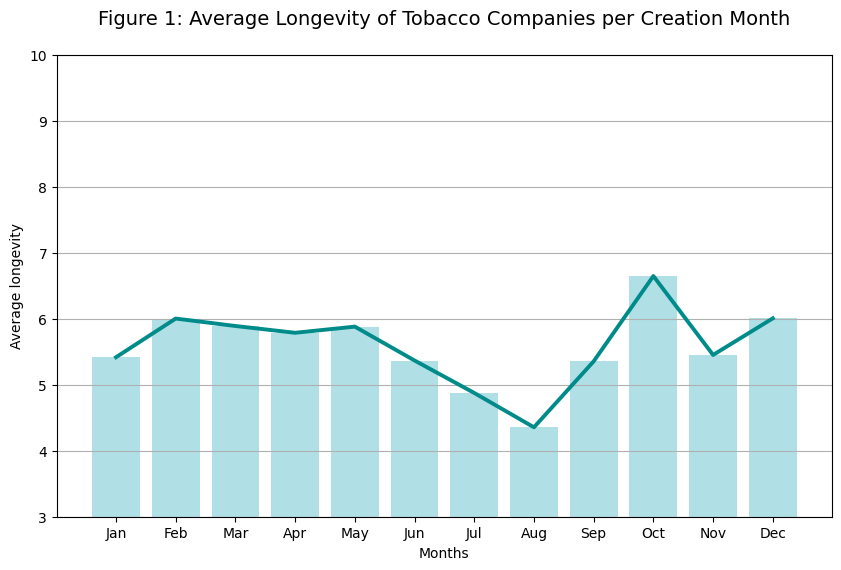

In [28]:
# Create a figure and ax plots
fig, ax = plt.subplots(figsize = (10,6))

# Set months variable into indices of grouped dataframe
months = tobacco_companies_by_month_df.index

# Set months variable into values of grouped dataframe
average_longevity_values = tobacco_companies_by_month_df.values

# Create a list of month labels 
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Plot bars of average longevity values per cretion month
plt.bar(months, average_longevity_values, color='powderblue')

# Plot a line of average longevity values per cretion month: line is drawn to visualize the trend more easily
plt.plot(months , average_longevity_values , linewidth=2.8 , color = 'darkcyan')

# Set title to the figure
ax.set_title("Figure 1: Average Longevity of Tobacco Companies per Creation Month\n", fontsize=14)

# Set label to x axis
ax.set_xlabel("Months")

# Set label to y axis
ax.set_ylabel("Average longevity")

# Put grids on the figure
plt.grid(axis='y')

# Limit y axis values from 3 to 10 for better visuality
ax.set_ylim([3,10])

# Set x labels into month labels
ax.set_xticklabels(months_labels)

# Save the figure in a folder in the current working directory
cwd = os.getcwd()
folder = os.path.join(cwd, 'figures')
os.makedirs(folder, exist_ok=True)
plt.savefig(os.path.join(folder,'Figure 1: Average Longevity of Tobacco Companies per Creation Month.jpg'), format='jpg')


# Display the figure
plt.show()

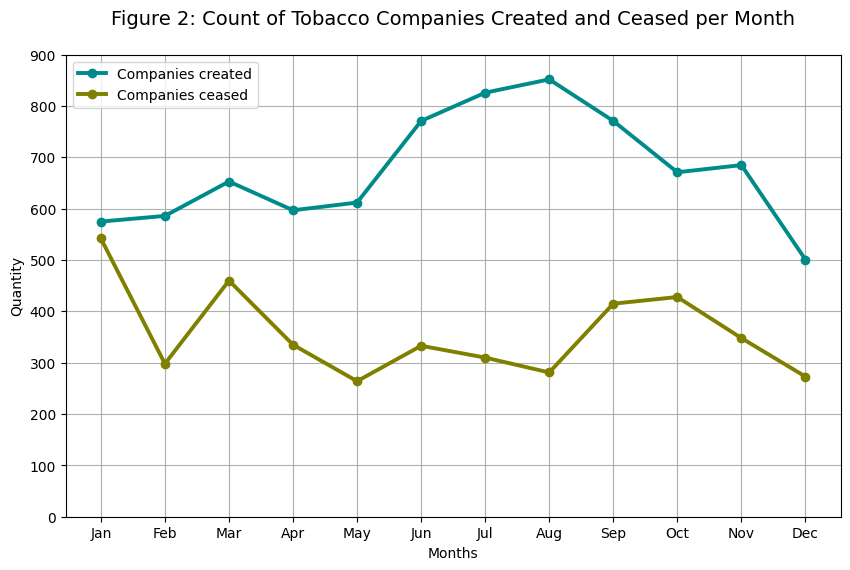

In [29]:
# Create a variable stroging frequencies of companies created
creation_count = tobacco_companies_creation_count_df.values

# Create a variable stroging frequencies of companies ceased
cessation_count = tobacco_companies_cessation_count_df.values

# Draw the plot
# Create a figure and ax plots
fig, ax = plt.subplots(figsize = (10,6))

# Set months variable into indices of grouped dataframe
months = tobacco_companies_by_month_df.index

# Set months variable into values of grouped dataframe
average_longevity_values = tobacco_companies_by_month_df.values

# Create a list of month labels 
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Plot a line of average longevity values per cretion month
plt.plot(months , creation_count , linewidth=2.8 , color = 'darkcyan', label='Companies created', marker='o')

# Plot a line of average longevity values per cretion month
plt.plot(months , cessation_count , linewidth=2.8 , color = 'olive', label='Companies ceased', marker='o')

# Set title to the figure
ax.set_title("Figure 2: Count of Tobacco Companies Created and Ceased per Month\n", fontsize=14)

# Set label to x axis
ax.set_xlabel("Months")

# Set label to y axis
ax.set_ylabel("Quantity")

# Put grids on the figure
plt.grid(axis='both')

# Set x labels into month labels
ax.set_xticklabels(months_labels)

# Put legend
plt.legend(loc='upper left')

# Limit y axis values from 0 to 900 for better visuality 
plt.ylim([0,900])

# Save the figure in a folder in the current working directory
os.makedirs(folder, exist_ok=True)
plt.savefig(os.path.join(folder,'Figure 2: Count of Tobacco Companies Created and Ceased per Month.jpg'), format='jpg')

# Display the figure
plt.show()